In [ ]:
import pandas as pd

# قراءة البيانات (سنكتفي بـ 200 ألف سطر لضمان سرعة الخريطة لاحقاً)
df = pd.read_csv('NYPD_Complaint_Data_Historic.csv', nrows=200000, low_memory=False)

# 1. حذف الصفوف اللي ما فيها إحداثيات (خط طول وعرض)
df = df.dropna(subset=['Latitude', 'Longitude'])

# 2. تحويل عمود التاريخ لصيغة يفهمها بايثون
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce')
df = df.dropna(subset=['CMPLNT_FR_DT']) # حذف التواريخ الخاطئة

# 3. استخراج الساعة واليوم (مفيد جداً للتحليل)
df['Hour'] = df['CMPLNT_FR_TM'].str.split(':').str[0].astype(int, errors='ignore')

print("تم التنظيف! عدد السجلات الجاهزة:", len(df))
df.head()


تم التنظيف! عدد السجلات الجاهزة: 196963


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,Hour
0,101109527,2015-12-31,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)",23
1,153401121,2015-12-31,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)",23
2,569369778,2015-12-31,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)",23
3,968417082,2015-12-31,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)",23
4,641637920,2015-12-31,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)",23


/tmp/ipython-input-946941012.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Hour', palette='viridis')


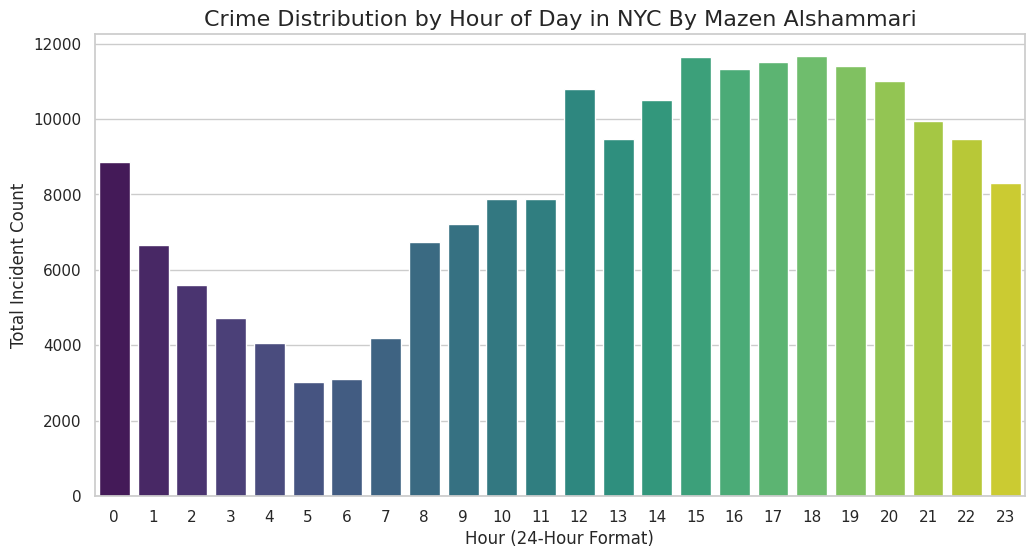

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for professional look
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Hour', palette='viridis')

# Adding labels in English to avoid text reversal
plt.title('Crime Distribution by Hour of Day in NYC By Mazen Alshammari', fontsize=16)
plt.xlabel('Hour (24-Hour Format)', fontsize=12)
plt.ylabel('Total Incident Count', fontsize=12)

plt.show()

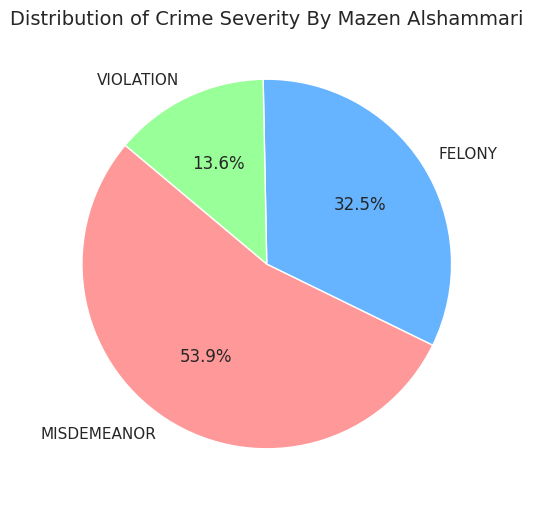

In [ ]:
# Count the occurrences of each law category
severity_counts = df['LAW_CAT_CD'].value_counts()

plt.figure(figsize=(10,6))
severity_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])

plt.title('Distribution of Crime Severity By Mazen Alshammari', fontsize=14)
plt.ylabel('') # Hiding the Y label for a cleaner look
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# 1. Initialize the map at NYC coordinates
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# 2. Extract Latitude and Longitude for the HeatMap (sampling 15,000 rows for speed)
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df.sample(15000).iterrows()]

# 3. Add the HeatMap layer
HeatMap(heat_data, radius=12, blur=15).add_to(nyc_map)

# 4. Display the map
nyc_map

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Encoding the target variable (Crime Severity)
le = LabelEncoder()
df['LAW_CAT_ENCODED'] = le.fit_transform(df['LAW_CAT_CD'])

# 2. Selecting Features (X) and Target (y)
# We will use Latitude, Longitude, and Hour to predict the Category
X = df[['Latitude', 'Longitude', 'Hour']]
y = df['LAW_CAT_ENCODED']

# 3. Splitting the data into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data is ready for training!")
print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

Data is ready for training!
Training samples: 157570 | Testing samples: 39393


In [ ]:
# 1. Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# 2. Train the model
print("Training the model... please wait.")
model.fit(X_train, y_train)

# 3. Make predictions on the test set
y_pred = model.predict(X_test)

print("Model Training Complete!")

Training the model... please wait.
Model Training Complete!


In [ ]:
# Print Accuracy and Classification Report
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Model Accuracy: 53.87%

Classification Report:

              precision    recall  f1-score   support

      FELONY       0.55      0.02      0.04     12805
 MISDEMEANOR       0.54      0.99      0.70     21152
   VIOLATION       0.67      0.00      0.00      5436

    accuracy                           0.54     39393
   macro avg       0.58      0.34      0.25     39393
weighted avg       0.56      0.54      0.39     39393



In [ ]:
# Fixed Function to predict crime type
def predict_crime(lat, lon, hour):
    # 1. Prepare the input data into a DataFrame
    input_data = pd.DataFrame([[lat, lon, hour]], columns=['Latitude', 'Longitude', 'Hour'])

    # 2. Make prediction using the trained model
    pred_encoded = model.predict(input_data)

    # 3. Decode the numeric result back to the original category name (Felony, etc.)
    pred_category = le.inverse_transform(pred_encoded)[0]

    return pred_category

# Test it again with NYC coordinates (Times Square area)
test_lat = 99.7580
test_lon = -73.9855
test_hour = 12

result = predict_crime(test_lat, test_lon, test_hour)
print(f"--- PREDICTION RESULT ---")
print(f"Predicted Crime Severity for this location at {test_hour}:00 is: {result}")

--- PREDICTION RESULT ---
Predicted Crime Severity for this location at 12:00 is: MISDEMEANOR


In [ ]:
print(df['LAW_CAT_CD'].value_counts())

LAW_CAT_CD
MISDEMEANOR    106118
FELONY          64100
VIOLATION       26745
Name: count, dtype: int64
